In [1]:
from plot_lib import *
from experiment_lib import load_constants_from_config
import json

In [2]:
# parse config
path = "exp-configs/EMEA/100/config-125M-nl.json"

with open(path, "r") as f:
    config = json.load(f)

# Load constants from config
(
    ROOT_DIR, 
    DATASET_DIR, 
    SOURCE_DIR, 
    DATASET_NAME, 
    EXPERIMENT_NAME, 
    NUM_TRIALS, 
    PREFIX_LEN, 
    SUFFIX_LEN, 
    PREPREFIX_LEN, 
    LANGUAGE, 
    SPLIT, 
    EXAMPLE_TOKEN_LEN, 
    SOURCE_FILE, 
    BATCH_SIZE, 
    MODEL_NAME, 
    TRAIN_FILE, 
    VAL_FILE, 
    VAL_SPLIT, 
    SEED
) = load_constants_from_config(config)

In [3]:
plot_max_BLEU(EXPERIMENT_NAME, MODEL_NAME, DATASET_DIR, LANGUAGE, EXAMPLE_TOKEN_LEN, PREFIX_LEN, NUM_TRIALS)

tmp/EMEA/nl/nl-100-100-125M/scores/sorted_compl_bleu_scores.jsonl
[{'exid': '27', 'scores': [{'trial': 19, 'score': 0.6701718440640347}, {'trial': 58, 'score': 0.6654206745970995}, {'trial': 32, 'score': 0.6619397230246019}, {'trial': 79, 'score': 0.657547499778844}, {'trial': 31, 'score': 0.6564918731002657}, {'trial': 64, 'score': 0.6556504347620531}, {'trial': 83, 'score': 0.6553562354636506}, {'trial': 66, 'score': 0.6532655842457863}, {'trial': 87, 'score': 0.6511246862185615}, {'trial': 53, 'score': 0.6491495938437237}, {'trial': 98, 'score': 0.6484046968809436}, {'trial': 99, 'score': 0.6469212021736067}, {'trial': 10, 'score': 0.6460465943557734}, {'trial': 20, 'score': 0.6460253448280024}, {'trial': 26, 'score': 0.6454611498575414}, {'trial': 25, 'score': 0.6445544773036761}, {'trial': 92, 'score': 0.6439142967022032}, {'trial': 95, 'score': 0.643543630088}, {'trial': 82, 'score': 0.6434823137053465}, {'trial': 85, 'score': 0.6427333668776306}, {'trial': 27, 'score': 0.6425251

IndexError: list index out of range

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


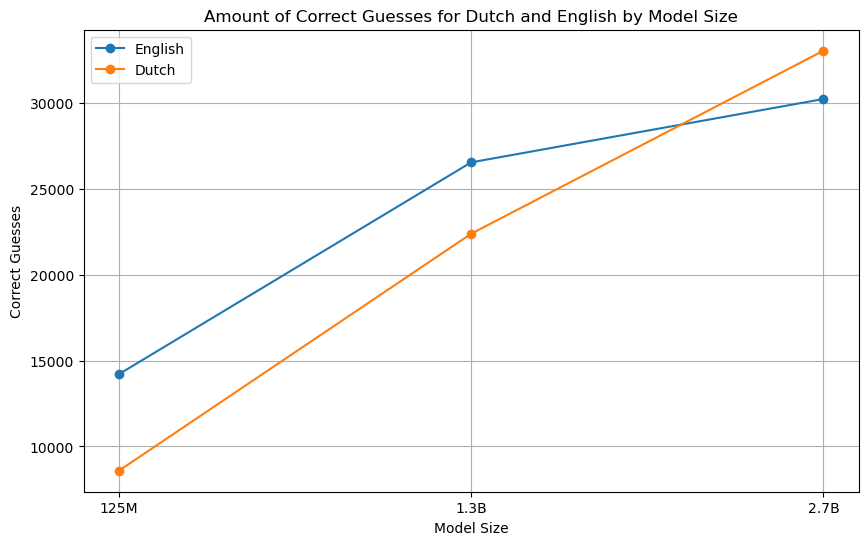

In [24]:
# Get the Wandb API key from environment variable
wandb_key = os.getenv('WANDB_API_KEY')
wandb.login(key=wandb_key)

# Initialize Wandb
wandb.init(
    project="thesis-llm-privacy",
    name="Number of correct guesses for model sizes and languages - " + DATASET_DIR,
    config={
        "dataset": DATASET_DIR,
        "language": LANGUAGE,
        "token_len": EXAMPLE_TOKEN_LEN,
        "prefix_len": PREFIX_LEN,
        "num_trials": NUM_TRIALS,
    },
)

base = os.path.join(ROOT_DIR, DATASET_DIR)
model_sizes = ["125M", "1.3B", "2.7B"]
languages = ["en", "nl"]

en_scores = []
nl_scores = []

for lang in languages:
    for size in model_sizes:
        acc_file = os.path.join(base, lang, f"{lang}-{EXAMPLE_TOKEN_LEN}-{NUM_TRIALS}-{size}", "accuracy.jsonl")
        with open(acc_file, 'r') as file:
            # Load the first line
            data = json.loads(file.readline())

            # Get the number of correct guesses
            correct = data['num_correct']
            exact = data['num_exact_match']
            if lang == "en":
                en_scores.append((size, correct, exact))
            if lang == "nl":
                nl_scores.append((size, correct, exact))

# Convert scores to a format suitable for Wandb Table
table = wandb.Table(columns=["Model Size", "Correct Guesses", "Exact Matches", "Language"])
for size, correct, exact in en_scores:
    table.add_data(size, correct, exact, "English")
for size, correct, exact in nl_scores:
    table.add_data(size, correct, exact, "Dutch")

# Log the table to Wandb
wandb.log({"Correct Guesses Comparison": table})

# Create plot
wandb.log({
    "Correct guesses comparison": wandb.plot.line_series(
        xs=[[size] for size, _, _ in en_scores] + [[size] for size, _, _ in nl_scores],
        ys=[[correct] for _, correct, _ in en_scores] + [[correct] for _, correct, _ in nl_scores],
        keys=["English"] * len(en_scores) + ["Dutch"] * len(nl_scores),
        title="Amount of Correct Guesses for Dutch and English by Model Size",
    )
})

# Plotting using matplotlib
fig = plt.figure(figsize=(10, 6))
plt.plot([size for size, _, _ in en_scores], [correct for _, correct, _ in en_scores], label='English', marker='o')
plt.plot([size for size, _, _ in nl_scores], [correct for _, correct, _ in nl_scores], label='Dutch', marker='o')
plt.xlabel('Model Size')
plt.ylabel('Correct Guesses')
plt.title('Amount of Correct Guesses for Dutch and English by Model Size')
plt.legend()
plt.grid(True)

# Log the figure to Wandb
wandb.log({"Correct Guesses Comparison Figure": wandb.Image(fig)})

# Show the plot
plt.show()


# Finish the Wandb run
wandb.finish()